# **Graph Neural Networks with PyTorch Geometric**
[Savannah Thais](https://github.com/savvy379) and [Gage DeZoort](https://github.com/gagedezoort)

Similar examples can be found at https://pytorch-geometric.readthedocs.io/en/latest/notes/colabs.html

**Introduction**
This notebook teaches the reader how to build Graph Neural Networks (GNNs) with Pytorch Geometric (PyG). First, we warm up building a random GNN by hand. Then, we walk through a simple GNN architecture applied to the Cora Dataset; it is a modified version of the PyG [Tutorial](https://pytorch-geometric.readthedocs.io/en/latest/notes/colabs.html) on node classifying GNNs. Then, we walk through a simple GNN architecture applied to the MUTAG Dataset; it is a modified version of teh PyG [Tutorial](https://colab.research.google.com/drive/1I8a0DfQ3fI7Njc62__mVXUlcAleUclnb?usp=sharing). Finally, we code a GNN based physics simulator using the WaterDropSmall Dataset, based on a Stanford [Tutorial](https://colab.research.google.com/drive/1hirUfPgLU35QCSQSZ7T2lZMyFMOaK_OF?usp=sharing#scrollTo=Q1E_PEIxaHr8).

A graph $G$ is a mathematical object consisting of a set of nodes (vertices) $V$ and edges $E$, i.e. $G=(V,E)$. Graphs can easily represent a wide range of structured data including atoms in molecules, users in a social network, cities and roads in a transportation system, players in team sports, objects interacting in a dynamical physical system, detector events , and more. The nodes and edges of the graph can have associated features as defined by the developer; these can include geometric information (ie particle hit locations in a detector) and non-geometric information (ie particle momenta). Graphs can be directed or undirected. A major advantage of GNNs is that they can handle input data of varying sizes: each graph processed by the network can have a different number of nodes and edges, making them well suited for a range of physics applications. Shown below are some examples from particle physics applications: (a) particle tracking, (b) calorimeter clustering, (c) event classification, and (d) jet tagging (image from [Graph Neural Networks in Particle Physics](https://iopscience.iop.org/article/10.1088/2632-2153)).

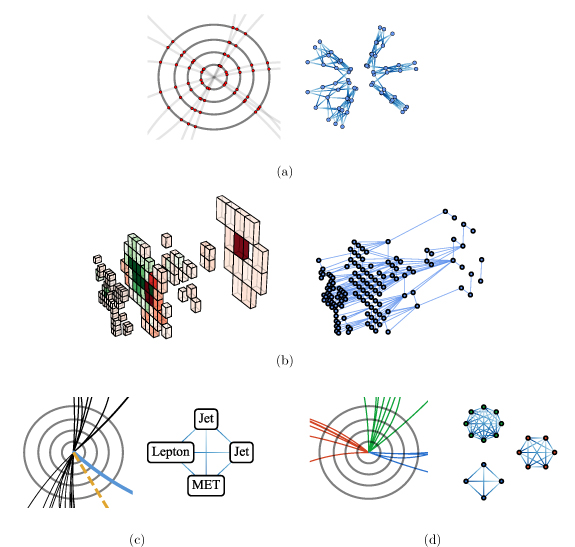

In general, GNNs work by leveraging local information across the graph structure to intelligently re-embed the edges and nodes. A commonly used class of GNNs (and the focus of this tutorial) is the Graph Convolutional Network (GCN). GCNs use the same convolution operations as in a normal CNN, but apply the convolutions to node neighborhoods rather than a fixed data tensor (like an image matrix). These are considered a type of "Message Passing Network" when are 'message' is constructed by combining and transforming information from neighboring nodes and that message is 'passed' to a target node and used to update its features. In this way the entire graph can be transformed such that each node is updated to include additional useful information. The convolved graph is typically then processed by an additional linear layer that uses node and or edge features to do classification or regression on individual graph elements, graph substructures, or the graph as a whole. (Note: the same message passing structure can be applied to edges instead of nodes to update edge features as well).
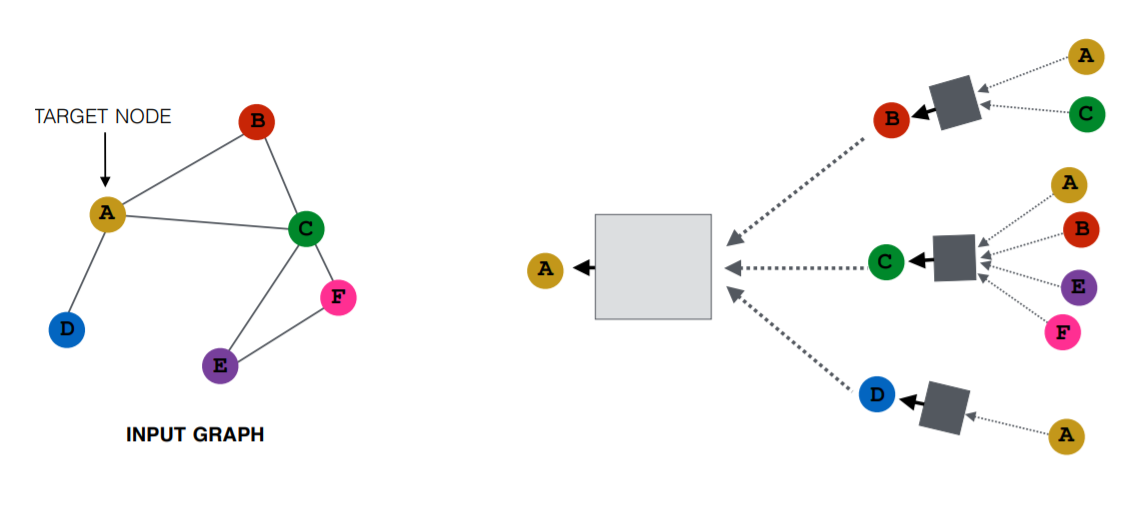

In mathematical terms, a single graph convolution layer can be described as:
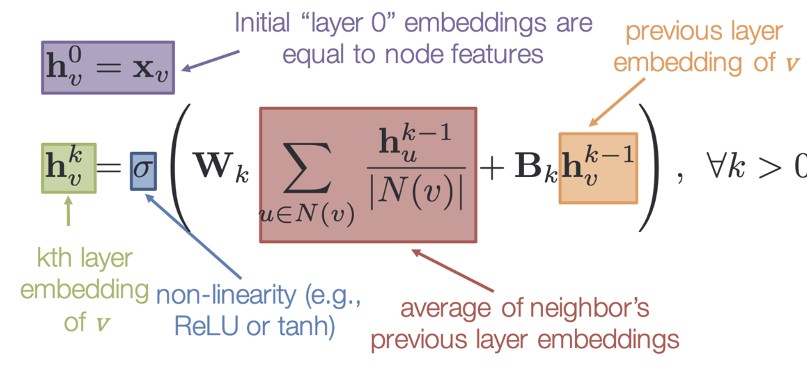

Here, $h_v^0$ is the initial embedding of node $v$ (ie the original node features). To update the embedding of node $v$, $h_v^k$, the 'message' is constructed by applying a function $f$ to a the average over the current embedding of all the neighboring nodes (nodes connected to $v$ by a graph edge): $N(v)$) $\sum_{u \in N(v)}\frac{h_u^{k-1}}{deg(v)}$ and, optionally, the current embedding of the target node: $h_v^{k-1}$ then passed through a non-linear activation function and used to update the target node. In practice the functions $f$ is approximated by a matrix (convolution) $W_k$ with the added non-linearity of the activation function.  

This entire process is visualized in the below diagram, taken from the excellent paper [A Practical Guide to Graph Neural Networks](https://arxiv.org/abs/2010.05234).
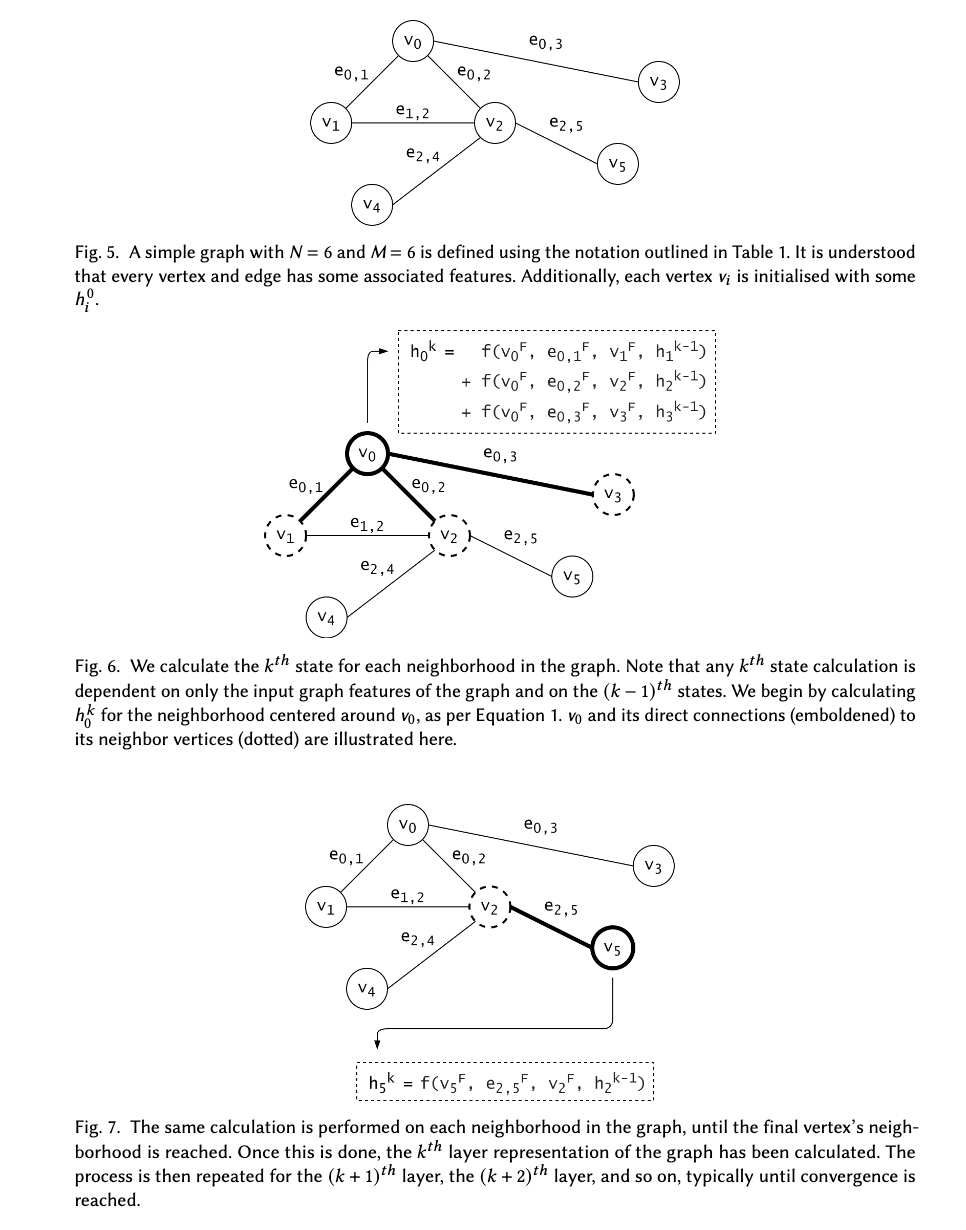

# Let's Start Coding!

## Installation etc.

In [1]:
import os
import torch
import pandas as pd
import numpy as np
import networkx
from matplotlib import pyplot as plt

# check the torch/cuda installations
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git


2.6.0+cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 2.8 MB/s eta 0:00:00


## Warm-up: PyG Graphs and the Karate Club

The Zachary Karate Club dataset (1977) is a social network describing friendships in a university karate club:
- 34 nodes (members of the karate club)
- 78 edges (friendships outside of the club)

A conflict arose between an instructor and an adminstrator, causing a faction in the club - half of the members formed a new karate club around the previous instructor and half either found a new instructor or quit karate.
- 34 truth labels (faction)

Let's import the data...

In [2]:
from torch_geometric.datasets import KarateClub

# KarateClub is a small, easily visualized community graph
karate_club = KarateClub().data

/usr/local/lib/python3.11/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [3]:
# more details about the graph
def get_graph_stats(data):
  print(f'Number of nodes: {data.num_nodes}')
  print(f'Number of edges: {data.num_edges}')
  print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
  print(f'Number of training nodes: {data.train_mask.sum()}')
  print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
  print(f'Has isolated nodes: {data.has_isolated_nodes()}')
  print(f'Has self-loops: {data.has_self_loops()}')
  print(f'Is undirected: {data.is_undirected()}')

get_graph_stats(karate_club)

Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Number of training nodes: 4
Training node label rate: 0.12
Has isolated nodes: False
Has self-loops: False
Is undirected: True


Truth labels tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])


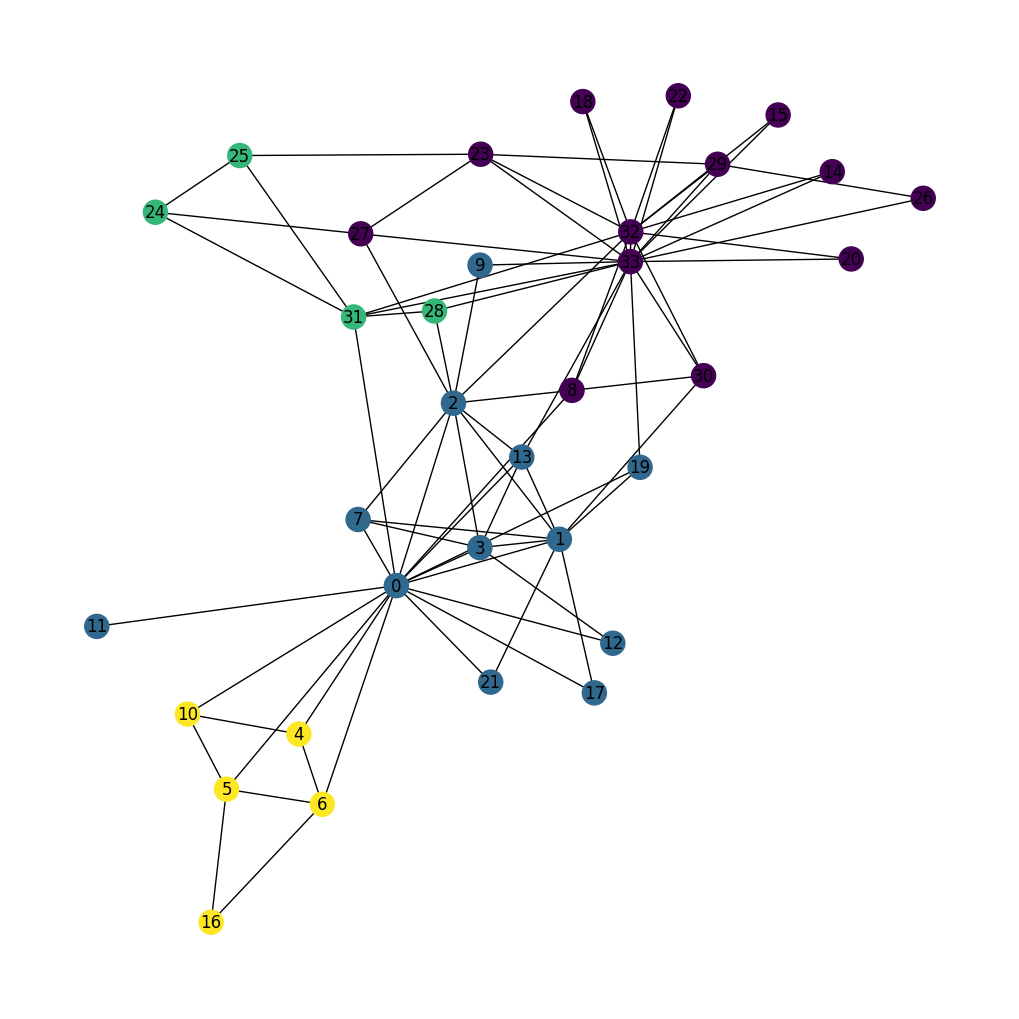

In [4]:
# let's visualize the graph
import torch_geometric
import networkx as networkx
print('Truth labels', karate_club.y)
karate_club_nx = torch_geometric.utils.to_networkx(karate_club, to_undirected=True)
plt.figure(figsize=(10,10))
networkx.draw_spring(karate_club_nx, with_labels=True, node_color=karate_club.y)

Pretty cool! In this graph, the color of the nodes represent which faction the club member falls into (stayed, new teachers, or quit karate) and the edges represent interpersonal connections between members. In a learning task on this graph, we might mask some or all of the truth labels of the nodes and try to predict them with a GNN.

As a brief aside, let's take a look at how PyG stores edges. In a fully connected graph, there are $\frac{1}{2}|V|(|V|-1)$ edges (where $|V|$ is the number of nodes). Sparse graphs have relatively few edges, i.e. $|E|\ll \frac{1}{2}|V|(|V|-1)$. Adjacency matrices aren't necessarily the best way to represent sparse graphs - instead, packages like PyG use edge index lists in COO format.

In [5]:
# edge representations

# edge lists (COO format)
out_nodes = karate_club.edge_index[0]
print('edges move out of the following nodes:\n', out_nodes)
in_nodes = karate_club.edge_index[1]
print('edges move into the following nodes:\n', in_nodes)

# adjacency representation
A = torch_geometric.utils.to_dense_adj(karate_club.edge_index).squeeze()
print('adjacency representation', A)

edges move out of the following nodes:
 tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
         3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,
         7,  7,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 11, 12, 12, 13, 13, 13,
        13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21,
        21, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 27, 27,
        27, 27, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 31, 31,
        31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33,
        33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33])
edges move into the following nodes:
 tensor([ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 17, 19, 21, 31,  0,  2,
         3,  7, 13, 17, 19, 21, 30,  0,  1,  3,  7,  8,  9, 13, 27, 28, 32,  0,
         1,  2,  7, 12, 13,  0,  6, 10,  0,  6, 10, 16,  0,  4,  

Adjacency matrices are a useful theoretical tool, though! In fact, we can use them to describe a graph convolutional network (GCN) as originally posed in [Semi-Supervised Classification with Graph Convolutional Networks
](https://arxiv.org/pdf/1609.02907.pdf).

### GCN Theory

Let's say we start with a graph described by node features $\mathbf{X}^{(0)}\in\mathbb{R}^{|V|\times d_\mathrm{in}}$ and edges connectivity summarized by adjacency matrix $\mathbf{A} \in [0,1]^{|V|\times|V|}$. The forward pass of a GCN works like this:

1. Add self loops (edges connected to the same node) to the adjacency matrix $$
\mathbf{A}\rightarrow \tilde{\mathbf{A}} = \mathbf{A}+\mathbf{I}
$$

2. Normalize $\tilde{A}$ by the node degrees at each end of the edge, i.e.
$$
\mathbf{P} = \tilde{\mathbf{D}}^{-1/2}\tilde{\mathbf{A}}\tilde{\mathbf{D}}^{-1/2}
\qquad
\tilde{\mathbf{D}} = \text{diag}(\text{deg}(u))
$$ so that each entry in the normalized adjacency matrix reads
$$
p_{uv} = \frac{\delta_{(u,v)\in E}}{\sqrt{\text{deg}(u)+1}\sqrt{\text{deg}(v)+1}}
$$

3. Use this normalized adjacency matrix with self loops and a matrix of learnable weights $\mathbf{W}^{(\ell+1)}$ to facilitate neural message passing (i.e. just neighborhood sums!):

$$
\mathbf{X}^{(\ell+1)} = \mathbf{P}\sigma(\mathbf{X}^{(\ell)})\mathbf{W}^{(\ell+1)}
$$

Here, $\sigma$ is any non-linearity (activation function).
This forward pass should look pretty familiar! It's just like the forward pass of a standard NN, except now we're multiplying by a matrix $\mathbf{P}$. Let's compare:

- DNN:
$$\mathbf{X}^{(\ell+1)} = \sigma(\mathbf{X}^{(\ell)})\mathbf{W}^{(\ell+1)}$$
- GCN:  
$$\mathbf{X}^{(\ell+1)} = \mathbf{P}\sigma(\mathbf{X}^{(\ell)})\mathbf{W}^{(\ell+1)}$$


We can re-cast the GCN matrix equation in terms of our familiar message-passing notation:

$$
\mathbf{x}_v^{(\ell + 1)} = \sum_{w \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{w,v}} \mathbf{x}_w^{(\ell)}\mathbf{W}^{(\ell + 1)}
$$

Here, $c_{w,v}$ refers to a fixed normalization coefficient for each edge. This should make it clear that $\mathbf{P}$ simply computes a weighted sum of the neighborhood features for each node - this is neural message passing. In contrast, a single NN layer is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{x}_v^{(\ell)}\mathbf{W}^{(\ell + 1)}
$$

which does not make use of neighboring node information.

### Building a GCN
Just for fun, let's first code up a random GCN by hand and try it out on the KarateClub dataset. We'll use matrix notation (as above) to make it clear what's happening.

In [6]:
# get the adjacency matrix
A = torch_geometric.utils.to_dense_adj(karate_club.edge_index).squeeze()
# add self loops
A_tilde = A + torch.eye(A.shape[0])
# calculate normalization
node_degrees = torch.sqrt(torch.sum(A_tilde, dim=1))
D_tilde_inv = torch.diag(1/node_degrees)

# P specifies our degree-normalized neighborhood sums
P = D_tilde_inv @ A_tilde @ D_tilde_inv
print(P)

tensor([[0.0588, 0.0767, 0.0731,  ..., 0.0917, 0.0000, 0.0000],
        [0.0767, 0.1000, 0.0953,  ..., 0.0000, 0.0000, 0.0000],
        [0.0731, 0.0953, 0.0909,  ..., 0.0000, 0.0836, 0.0000],
        ...,
        [0.0917, 0.0000, 0.0000,  ..., 0.1429, 0.1048, 0.0891],
        [0.0000, 0.0000, 0.0836,  ..., 0.1048, 0.0769, 0.0654],
        [0.0000, 0.0000, 0.0000,  ..., 0.0891, 0.0654, 0.0556]])


**Question**: what shape should **P** be?

In [7]:
##print(P.shape)

Now we'll construct our GCN!

In [8]:
from torch.nn import ReLU
relu = ReLU() # our non-linear activation function!

We'll define a random weight matrix to produce dim-2 outputs on each Karate Club member node

In [9]:
# let's define a random weight matrix to produce dim-2 outputs for each KarateClub node
X0 = karate_club.x
## First GNN layer
n1 = 8
W1 = (2*torch.rand(X0.shape[1], n1)-1) * np.sqrt(6) / np.sqrt(X0.shape[1] + n1) # xavier/glorot init
X1 = P @ X0 @ W1
## second GNN layer
n2 = 2
W2 = (2*torch.rand(X1.shape[1], n2)-1) * np.sqrt(6) / np.sqrt(X1.shape[1] + n2) # xavier/glorot init
X2 = P @ X1 @ W2

Now we can plot our updated graph (we are using the 2-dim features on each node as their coordinates)

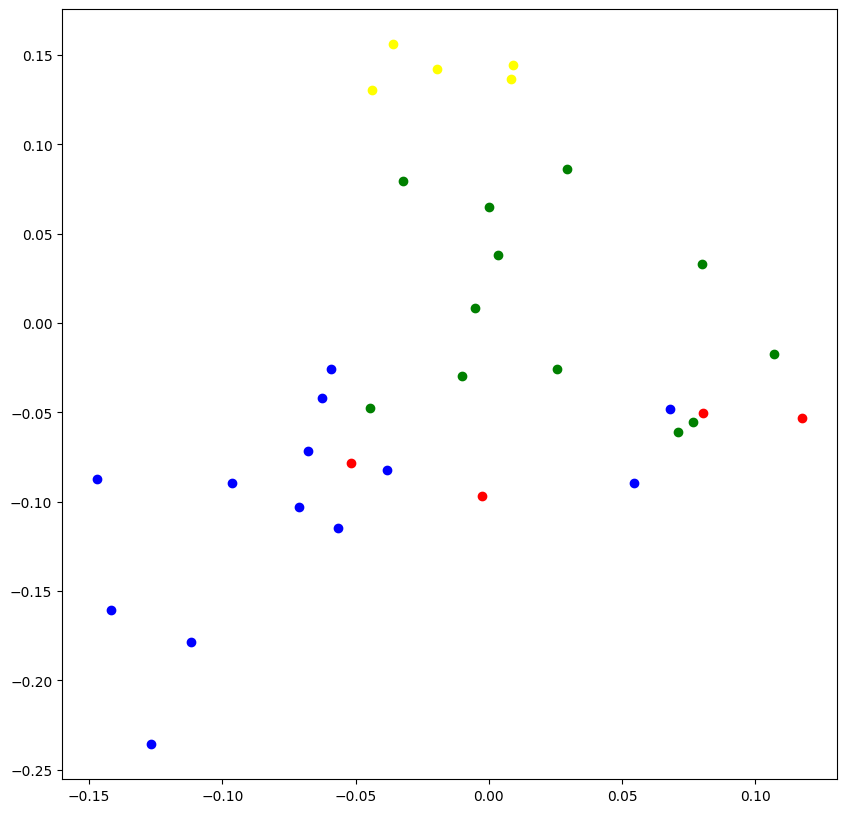

In [10]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,10))
for i, c in enumerate(['blue', 'green', 'red', 'yellow']):
  in_class = X2[karate_club.y==i]
  ax.scatter(in_class[:,0], in_class[:,1], c=c)
plt.show()

We're not actually learning anything here, we're just applying a randomly initialized GCN to the Karate Club data, but it's good to build intuition about how these models work!

**Question:** what would we want this GNN to do if we were actually training it?

## Scaling up: the Cora dataset

We will now use the [Cora dataset](https://relational.fit.cvut.cz/dataset/CORA) to predict the subject of a research paper given its words and citation network. The cora dataset consists of

- 2,708 nodes (scientific papers)
- 7 truth classes (paper subjects)
- 5,429 edges (representing citations)
- 1,433 node features (each a binary field indicating the presence of a word in the corresponding paper)

Let's go!

In [11]:
# import the cora citation network
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

Processing...
Done!


In [12]:
# there is only one graph in this dataset
cora = dataset[0]
cora

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [13]:
get_graph_stats(cora)

Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


We can see that the `Cora` network holds 2,708 nodes and 10,556 edges, resulting in an average node degree of 3.9.
For training this dataset, we are given the ground-truth categories of 140 nodes (20 for each class).
This results in a training node label rate of only 5%.

In contrast to `KarateClub`, this graph holds the additional attributes `val_mask` and `test_mask`, which denotes which nodes should be used for validation and testing.

Furthermore, we make use of **[data transformations](https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html#data-transforms) via `transform=NormalizeFeatures()`**.
Transforms can be used to modify your input data before inputting them into a neural network, *e.g.*, for normalization or data augmentation.
Here, we [row-normalize](https://pytorch-geometric.readthedocs.io/en/latest/modules/transforms.html#torch_geometric.transforms.NormalizeFeatures) the bag-of-words input feature vectors.

We can further see that this network is undirected, and that there exists no isolated nodes (each document has at least one citation).

We can use the `networkx` package to visualize the papers in the citation graph format. Each node will represent an idividual paper, nodes will be connected by an edge if one paper cites the other, and the color of each node will represent subject area.

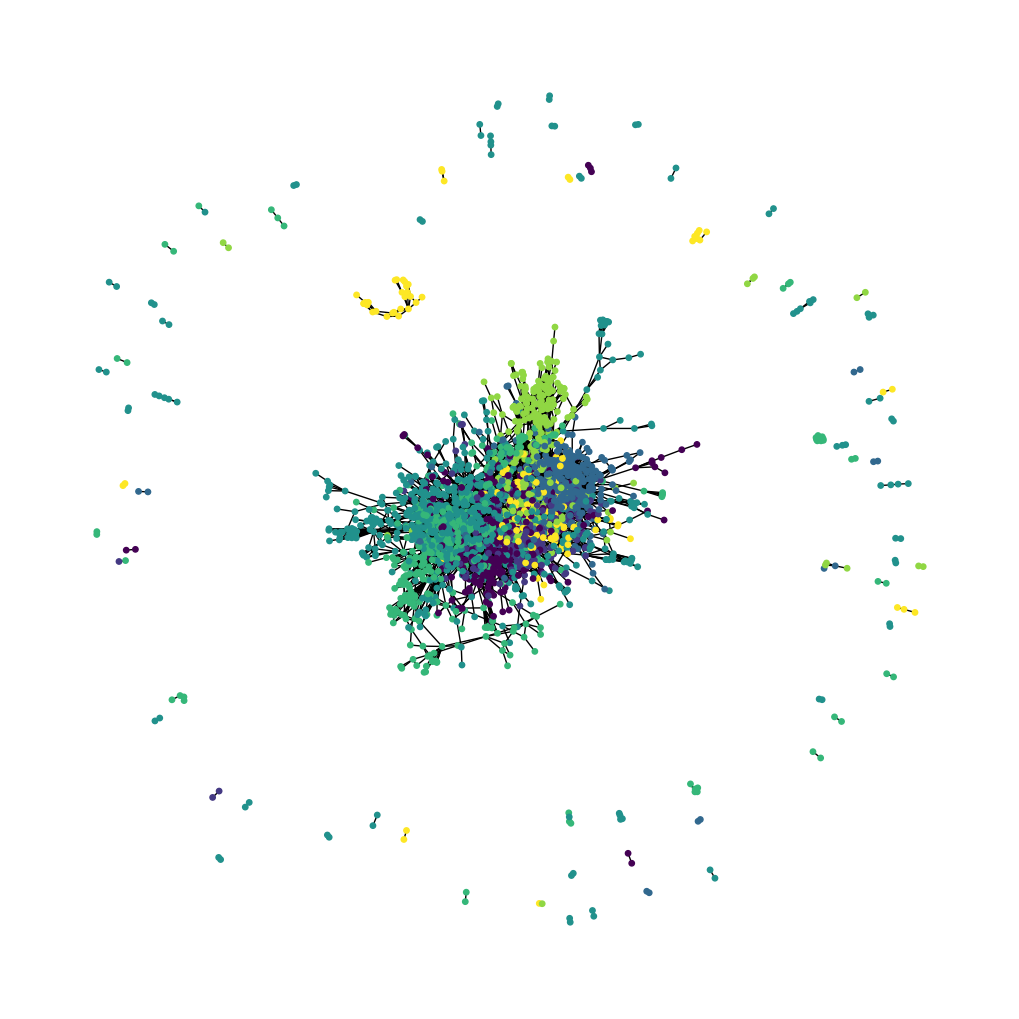

In [14]:
# let's visualize the graph
plt.figure(figsize=(10,10))
cora_nx = torch_geometric.utils.to_networkx(cora, to_undirected=True)
networkx.draw(cora_nx, node_size=15, node_color=cora.y)

### First, an MLP
In theory, we should be able to infer the category of a document solely based on its content, *i.e.* its bag-of-words feature representation, without taking any relational information into account.

Let's test that by constructing a simple MLP that solely operates on input node features (using shared weights across all nodes):

In [15]:
from torch.nn import Linear
import torch.nn.functional as F


class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

model = MLP(hidden_channels=16)
print(model)

MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
)


In [16]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

data = cora
model = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

for epoch in range(1, 201):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.9615
Epoch: 002, Loss: 1.9557
Epoch: 003, Loss: 1.9505
Epoch: 004, Loss: 1.9423
Epoch: 005, Loss: 1.9327
Epoch: 006, Loss: 1.9279
Epoch: 007, Loss: 1.9144
Epoch: 008, Loss: 1.9087
Epoch: 009, Loss: 1.9023
Epoch: 010, Loss: 1.8893
Epoch: 011, Loss: 1.8776
Epoch: 012, Loss: 1.8594
Epoch: 013, Loss: 1.8457
Epoch: 014, Loss: 1.8365
Epoch: 015, Loss: 1.8280
Epoch: 016, Loss: 1.7965
Epoch: 017, Loss: 1.7984
Epoch: 018, Loss: 1.7832
Epoch: 019, Loss: 1.7495
Epoch: 020, Loss: 1.7441
Epoch: 021, Loss: 1.7188
Epoch: 022, Loss: 1.7124
Epoch: 023, Loss: 1.6785
Epoch: 024, Loss: 1.6660
Epoch: 025, Loss: 1.6119
Epoch: 026, Loss: 1.6236
Epoch: 027, Loss: 1.5827
Epoch: 028, Loss: 1.5784
Epoch: 029, Loss: 1.5524
Epoch: 030, Loss: 1.5020
Epoch: 031, Loss: 1.5065
Epoch: 032, Loss: 1.4742
Epoch: 033, Loss: 1.4581
Epoch: 034, Loss: 1.4246
Epoch: 035, Loss: 1.4131
Epoch: 036, Loss: 1.4112
Epoch: 037, Loss: 1.3923
Epoch: 038, Loss: 1.3055
Epoch: 039, Loss: 1.2982
Epoch: 040, Loss: 1.2543


After training the model, we can call the `test` function to see how well our model performs on unseen labels.
Here, we are interested in the accuracy of the model, *i.e.*, the ratio of correctly classified nodes:

In [17]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.5900


Hmmm...our MLP performs rather bad with only about 59% test accuracy.

**Question:** Why do you think the MLP doesn't perform well? Would a GNN be better instead? Why?

### Now, a GNN

Okay, now it's time to set up a GCN using PyG! We can construct a GNN in PyG similary to how we built our MLP. We just need to swap the `torch.nn.Linear` layers with PyG's `GCNConv` implementing the graph convolution:

$$
\mathbf{x}_v^{(\ell + 1)} =  \sum_{w \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{w,v}} \mathbf{x}_w^{(\ell)}\mathbf{W}^{(\ell + 1)}
$$

In [18]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

We're just trying to predict the right subject for each paper, hence the `log_softmax` post-activation. This GCN is very similar to the [original implementation](https://github.com/tkipf/pygcn).

Let's take a look at the predictions of an untrained GCN by looking at a low dimensional representation. Again, each color will represent a different paper subject:

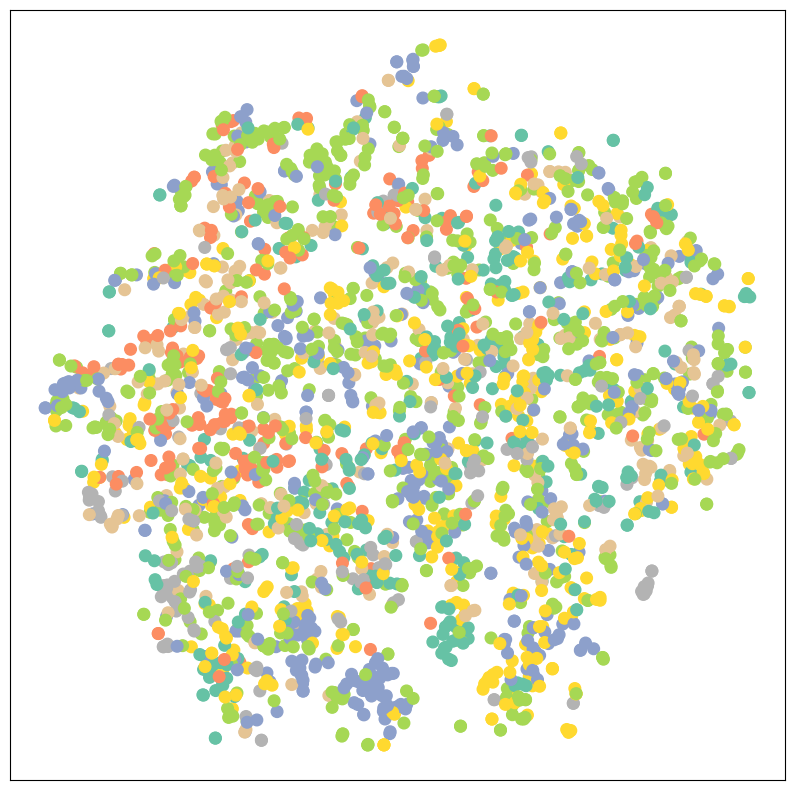

In [19]:
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

# examine the output of an untrained GCN
model = GCN()
model.eval()
out = model(cora)
visualize(out, color=cora.y)

Unsurprisingly, not very useful. All of the different paper topics are mixed in latent space.

Now let's train our GNN!

In [20]:
model = GCN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train(data):
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test(data):
      model.eval()
      out = model(data)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

for epoch in range(1, 101):
    loss = train(cora)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.9462
Epoch: 002, Loss: 1.9404
Epoch: 003, Loss: 1.9364
Epoch: 004, Loss: 1.9261
Epoch: 005, Loss: 1.9169
Epoch: 006, Loss: 1.9122
Epoch: 007, Loss: 1.9059
Epoch: 008, Loss: 1.8901
Epoch: 009, Loss: 1.8856
Epoch: 010, Loss: 1.8703
Epoch: 011, Loss: 1.8604
Epoch: 012, Loss: 1.8458
Epoch: 013, Loss: 1.8449
Epoch: 014, Loss: 1.8221
Epoch: 015, Loss: 1.8062
Epoch: 016, Loss: 1.7951
Epoch: 017, Loss: 1.7799
Epoch: 018, Loss: 1.7742
Epoch: 019, Loss: 1.7569
Epoch: 020, Loss: 1.7422
Epoch: 021, Loss: 1.7220
Epoch: 022, Loss: 1.7161
Epoch: 023, Loss: 1.6841
Epoch: 024, Loss: 1.6834
Epoch: 025, Loss: 1.6662
Epoch: 026, Loss: 1.6204
Epoch: 027, Loss: 1.6271
Epoch: 028, Loss: 1.6024
Epoch: 029, Loss: 1.5807
Epoch: 030, Loss: 1.5717
Epoch: 031, Loss: 1.5572
Epoch: 032, Loss: 1.5220
Epoch: 033, Loss: 1.4976
Epoch: 034, Loss: 1.4899
Epoch: 035, Loss: 1.4769
Epoch: 036, Loss: 1.4426
Epoch: 037, Loss: 1.4220
Epoch: 038, Loss: 1.4020
Epoch: 039, Loss: 1.3793
Epoch: 040, Loss: 1.3772


In [21]:
test_acc = test(cora)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8140


Not perfect, but it's much better at predicting paper subject area than our MLP! Just by leveraging the relational information.

We can further verify that  by looking at the output embeddings of our **trained** model, which now produces a far better clustering of nodes of the same category.

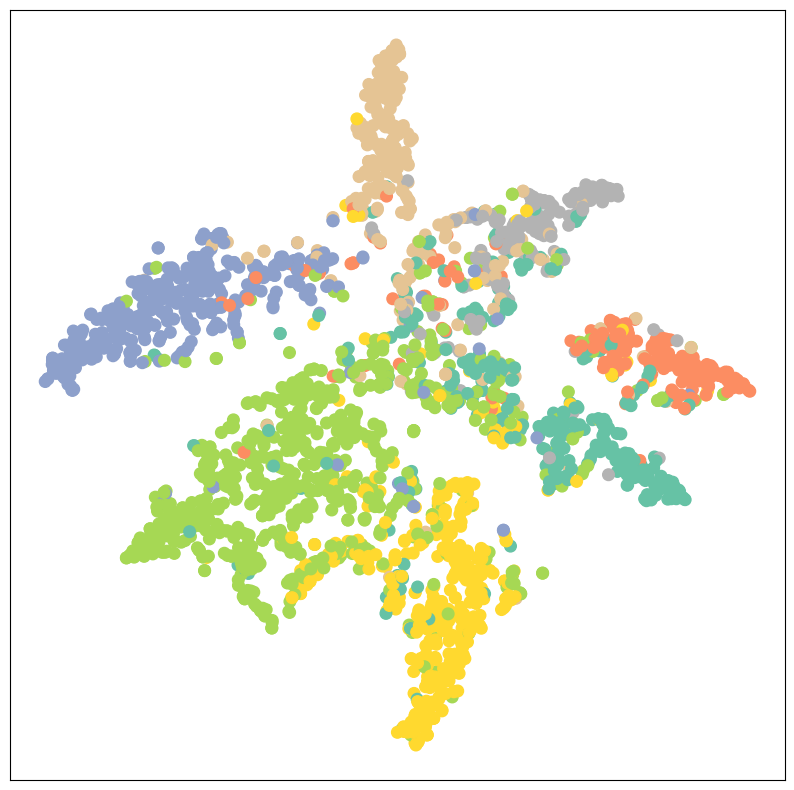

In [22]:
model.eval()

out = model(cora)
visualize(out, color=cora.y)

### GCNs in PyG
You may be wondering how the PyG implementation of the GCN compares to our matrix version above. Well, according to the [docs](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv),
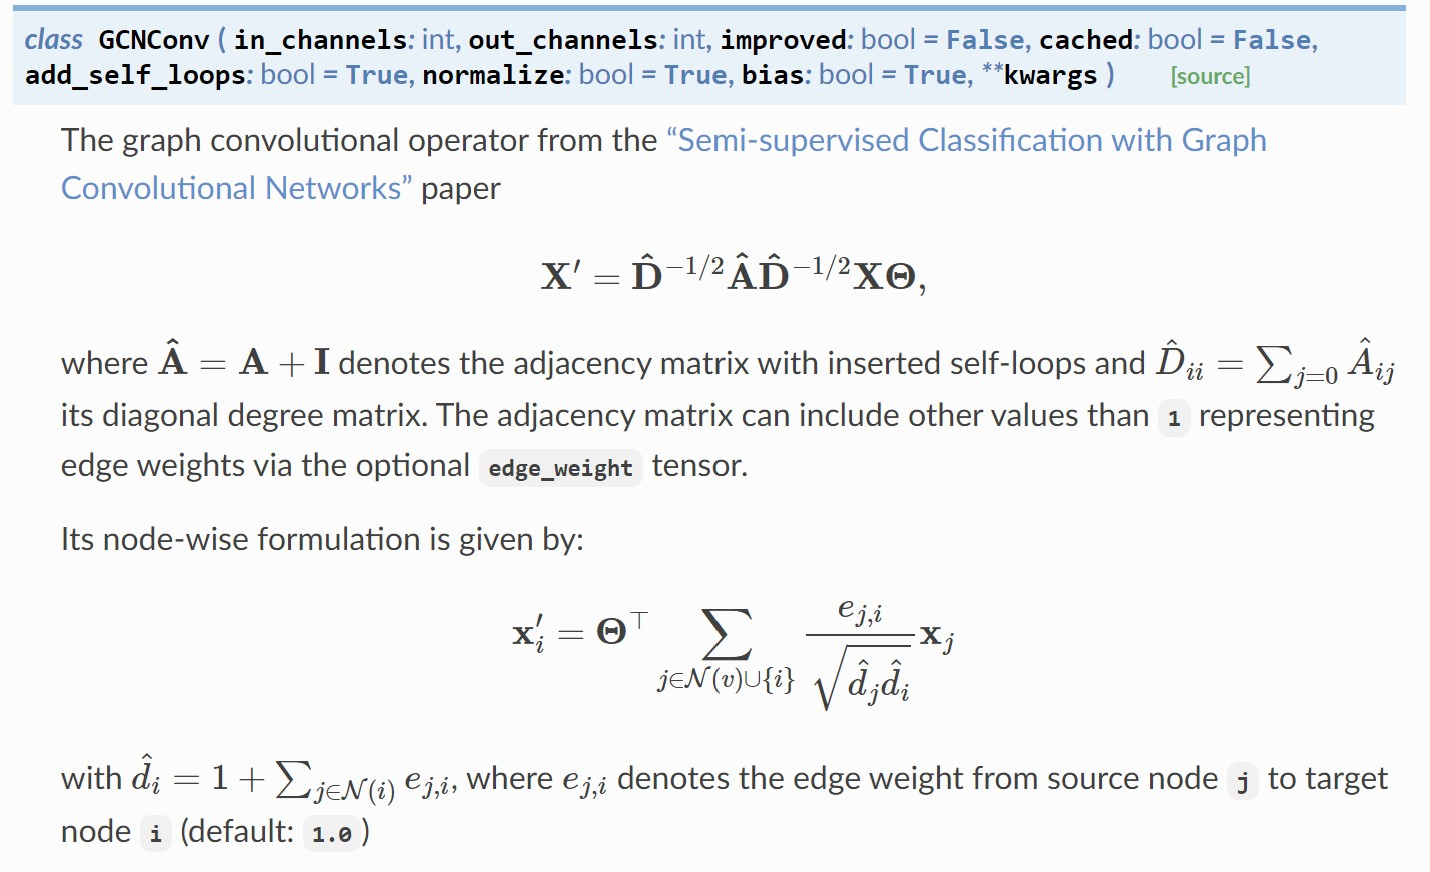
This is exactly the matrix equation we found above! Let's see how the PyG implementation works using a simplified version of the default code (https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/nn/conv/gcn_conv.html#GCNConv):


In [23]:
from typing import Optional

from torch import Tensor
from torch.nn import Parameter
from torch_scatter import scatter_add
from torch_sparse import SparseTensor, fill_diag, matmul, mul
from torch_sparse import sum as sparsesum

from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.dense.linear import Linear
from torch_geometric.nn.inits import zeros
from torch_geometric.typing import Adj, OptTensor, PairTensor
from torch_geometric.utils import add_remaining_self_loops
from torch_geometric.utils.num_nodes import maybe_num_nodes

def gcn_norm(edge_index, edge_weight=None, num_nodes=None,
             add_self_loops=True, dtype=None):

    num_nodes = maybe_num_nodes(edge_index, num_nodes)

    # we can optionally provide edge weights (1D features per edge)
    if edge_weight is None:
        edge_weight = torch.ones((edge_index.size(1), ), dtype=dtype,
                                  device=edge_index.device)

    # we also have the option to add self loops (like in the original implementation)
    if add_self_loops:
        edge_index, tmp_edge_weight = add_remaining_self_loops(
            edge_index, edge_weight, 1, num_nodes)
        assert tmp_edge_weight is not None
        edge_weight = tmp_edge_weight

    row, col = edge_index[0], edge_index[1]
    deg = scatter_add(edge_weight, col, dim=0, dim_size=num_nodes)
    deg_inv_sqrt = deg.pow_(-0.5)
    deg_inv_sqrt.masked_fill_(deg_inv_sqrt == float('inf'), 0)
    return edge_index, deg_inv_sqrt[row] * edge_weight * deg_inv_sqrt[col]

class SimpleGCNConv(MessagePassing):
    def __init__(self, in_channels: int, out_channels: int,
                 add_self_loops: bool = True, normalize: bool = True,
                 **kwargs):

        kwargs.setdefault('aggr', 'add')
        super().__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.add_self_loops = add_self_loops
        self.normalize = normalize
        self.lin = Linear(in_channels, out_channels, bias=False,
                          weight_initializer='glorot')
        self.reset_parameters()

    def reset_parameters(self):
        self.lin.reset_parameters()

    def forward(self, x: Tensor, edge_index: Adj,
                edge_weight: OptTensor = None) -> Tensor:
        if self.normalize:
            edge_index, edge_weight = gcn_norm(
                edge_index, edge_weight, x.size(self.node_dim),
                self.add_self_loops
            )
        x = self.lin(x)
        out = self.propagate(edge_index, x=x, edge_weight=edge_weight,
                             size=None)
        return out

    def message(self, x_j: Tensor, edge_weight: OptTensor) -> Tensor:
        return x_j if edge_weight is None else edge_weight.view(-1, 1) * x_j

        self.out_channels = out_channels
        self.add_self_loops = add_self_loops
        self.normalize = normalize
        self.lin = Linear(in_channels, out_channels, bias=False,
                          weight_initializer='glorot')
        self.reset_parameters()

    def reset_parameters(self):
        self.lin.reset_parameters()

    def forward(self, x: Tensor, edge_index: Adj,
                edge_weight: OptTensor = None) -> Tensor:
        if self.normalize:
            edge_index, edge_weight = gcn_norm(
                edge_index, edge_weight, x.size(self.node_dim),
                self.add_self_loops
            )
        x = self.lin(x)
        out = self.propagate(edge_index, x=x, edge_weight=edge_weight,
                             size=None)
        return out

Let's step back to the KarateClub dataset and see how this `gcn_norm` function works:

In [24]:
edge_index, edge_weight = gcn_norm(karate_club.edge_index, edge_weight=None, num_nodes=karate_club.num_nodes,
                                    add_self_loops=True)
print(edge_weight)

tensor([0.0767, 0.0731, 0.0917, 0.1213, 0.1085, 0.1085, 0.1085, 0.0990, 0.1213,
        0.1715, 0.1400, 0.0990, 0.1400, 0.1213, 0.1400, 0.0917, 0.0767, 0.0953,
        0.1195, 0.1414, 0.1291, 0.1826, 0.1581, 0.1826, 0.1414, 0.0731, 0.0953,
        0.1140, 0.1348, 0.1231, 0.1741, 0.1231, 0.1348, 0.1508, 0.0836, 0.0917,
        0.1195, 0.1140, 0.1690, 0.2182, 0.1543, 0.1213, 0.2236, 0.2500, 0.1085,
        0.2000, 0.2236, 0.2582, 0.1085, 0.2236, 0.2000, 0.2582, 0.1085, 0.1414,
        0.1348, 0.1690, 0.0990, 0.1231, 0.1826, 0.1132, 0.0962, 0.1741, 0.1361,
        0.1213, 0.2500, 0.2236, 0.1715, 0.1400, 0.2182, 0.0990, 0.1291, 0.1231,
        0.1543, 0.0962, 0.1601, 0.1361, 0.1601, 0.1361, 0.2582, 0.2582, 0.1400,
        0.1826, 0.1601, 0.1361, 0.1213, 0.1581, 0.1179, 0.1601, 0.1361, 0.1400,
        0.1826, 0.1601, 0.1361, 0.2041, 0.1826, 0.1826, 0.1132, 0.0962, 0.2500,
        0.2236, 0.1890, 0.2041, 0.2500, 0.1890, 0.2582, 0.1361, 0.1348, 0.1826,
        0.2236, 0.1054, 0.1508, 0.1890, 

Do these look familiar? These are just the entries of $\mathbf{P}=\tilde{\mathbf{D}}^{-1/2}\tilde{\mathbf{A}}\tilde{\mathbf{D}}^{-1/2}$ corresponding to each edge! For example:

In [25]:
# check a few examples
def check_edge(idx):
  print(f'\nChecking edge #{idx}')
  out_node, in_node = edge_index[:,idx]
  print(f'...edge extends from {out_node} to {in_node}')
  print(f'...corresponding entry in P: {P[out_node, in_node]}')
  print(f'...corresponding entry in edge_weights: {edge_weight[idx]}')

check_edge(29)
check_edge(3)
check_edge(0)


Checking edge #29
...edge extends from 2 to 8
...corresponding entry in P: 0.12309148907661438
...corresponding entry in edge_weights: 0.12309148907661438

Checking edge #3
...edge extends from 0 to 4
...corresponding entry in P: 0.12126781791448593
...corresponding entry in edge_weights: 0.12126781791448593

Checking edge #0
...edge extends from 0 to 1
...corresponding entry in P: 0.0766965001821518
...corresponding entry in edge_weights: 0.0766965001821518


Evidently, PyG computes the exact same matrix $\textbf{P}$ and maps it onto an edge weight vector `edge_weight`$\in\mathbb[0,1]^{2\times|E|}$. Instead of multiplying matrices, PyG keeps track of edge lists and uses element-wise indexing/multiplication.

So, we get the right normalization. That's great! Now how do we compute a message passing iteration without matrix multiplication by $\mathbf{P}$?

Let's look at the forward pass:

```
def forward(self, x: Tensor, edge_index: Adj,
                edge_weight: OptTensor = None) -> Tensor:
        if self.normalize:
            edge_index, edge_weight = gcn_norm(  
                edge_index, edge_weight, x.size(self.node_dim),
                self.add_self_loops
            )
        x = self.lin(x)
        out = self.propagate(edge_index, x=x, edge_weight=edge_weight,
                             size=None)
        return out     
```

In the first lines we call the `normalize` function to build the $\mathbf{P}$ matrix in the form of `edge_weights`. That checks out!

`edge_weights` $\leftrightarrow\ \mathbf{P}$

Next, we apply a learnable linear transform to our input feature,

$$ \texttt{x = self.lin(x)}\ \leftrightarrow\ \mathbf{X}^{(\ell+1)}=\mathbf{X}^{(\ell)}\mathbf{W}^{(\ell+1)}$$

We then call `self.propagate`, which initiates message passing under the hood. This is a PyG convention; whenever `propagate` is called, pairs of nodes ($\mathbf{x}_i, \mathbf{x}_j$) connected by an edge in `edge_index` are formed and passed through the user-defined `message` function. Here, we've defined:

```
def message(self, x_j: Tensor, edge_weight: OptTensor) -> Tensor:
        return x_j if edge_weight is None else edge_weight.view(-1, 1) * x_j
        
```

As we saw above, each message from node $j$ to node $i$ is just $\frac{1}{c_{j,i}} \cdot \mathbf{x}_j^{(\ell)}$, where $c_{j,i}=\sqrt{\text{deg}(j)+1}\sqrt{\text{deg}(i)+1}$ is the normalization constant in $\mathbf{P}$ (`edge_weight`).

Finally, PyG calls `aggregate` based on the user's choice of aggregation function. Since the GCN aggregation strategy is matrix multiplication, we're using `add` aggregation. We set this as a default kwarg in the `SimpleGCNConv` class. The PyG message passing `update` function updates the state of each node based on these aggregated messages (in general by applying another NN to them, but here we simply take the sum).

$$ \texttt{message}, \texttt{aggregate} \leftrightarrow\ \mathbf{P}\mathbf{X}^{(\ell)}\mathbf{W}^{(\ell+1)}$$
$$ \texttt{update}\ \leftrightarrow\ \mathbf{X}^{(\ell+1)} = \mathbf{P}\mathbf{X}^{(\ell)}\mathbf{W}^{(\ell+1)}$$

Schematically, based on https://pytorch-geometric.readthedocs.io/en/latest/notes/sparse_tensor.html

```
from torch_scatter import scatter

x = ...           # Node features of shape [num_nodes, num_features]
edge_index = ...  # Edge indices of shape [2, num_edges]
edge_weight = ... # Edge weights of shape [1, num_edges]

x_j = x[edge_index[0]]  # Source node features [num_edges, num_features]
x_i = x[edge_index[1]]  # Target node features [num_edges, num_features]

msg = edge_weight.view(-1,1) * x_j  # Compute message for each edge

# Aggregate messages based on target node indices
out = scatter(msg, edge_index[1], dim=0, dim_size=x.size(0), reduce="add")
```


### Wrap Up
Nice! We've used PyG to build an effective GNN that re-embeds the initial Cora dataset graph into a space more useful for node label prediction.

### Additional (Optional) Exercises
- To achieve better model performance and to avoid overfitting, it is usually a good idea to select the best model based on an additional validation set.
The `Cora` dataset provides a validation node set as `data.val_mask`, but we haven't used it yet.
Can you modify the code to select and test the model with the highest validation performance?
This should bring test performance to **82% accuracy**.

- How does GCN behave when increasing the hidden feature dimensionality or the number of layers? Does increasing the number of layers help at all?

- So far, we've just looked at GCNConv operations. You can try to use different GNN layers to see how model performance changes. What happens if you swap out all GCNConv instances with GATConv layers that make use of attention? Try to write a 2-layer GAT model that makes use of 8 attention heads in the first layer and 1 attention head in the second layer, uses a dropout ratio of 0.6 inside and outside each GATConv call, and uses a hidden_channels dimensions of 8 per head.

## Now, Graph Level Classification!

Graph classification refers to the problem of classifiying entire graphs (in contrast to nodes), given a **dataset of graphs**, based on some structural graph properties.
Here, we want to embed entire graphs, and we want to embed those graphs in such a way so that they are linearly separable given a task at hand.
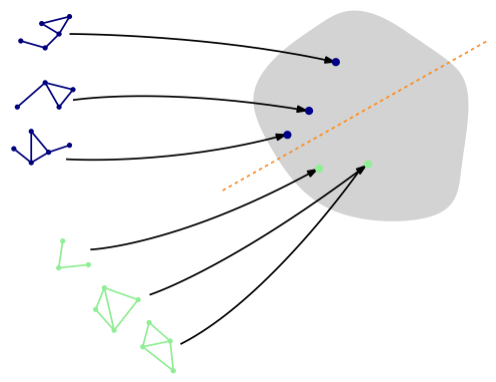

### MUTAG Dataset
One of the most common task for graph classification is **molecular property prediction**, in which molecules are represented as graphs, and the task may be to infer whether a molecule inhibits HIV virus replication or not.

The TU Dortmund University has collected a wide range of different graph classification datasets, known as the [**TUDatasets**](https://chrsmrrs.github.io/datasets/), which are also accessible via [`torch_geometric.datasets.TUDataset`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.TUDataset) in PyTorch Geometric.
Let's load and inspect one of the smaller ones, the **MUTAG dataset**:

In [26]:
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='data/TUDataset', name='MUTAG')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')


Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2


Processing...
Done!


In [27]:
## get the first graph object and print some info
data = dataset[0]
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Number of nodes: 17
Number of edges: 38
Average node degree: 2.24
Has isolated nodes: False
Has self-loops: False
Is undirected: True


This dataset provides **188 different graphs**, and the task is to classify each graph into **one out of two classes**.

By inspecting the first graph object of the dataset, we can see that it comes with **17 nodes (with 7-dimensional feature vectors)** and **38 edges** (leading to an average node degree of 2.24).
It also comes with exactly **one graph label** (`y=[1]`), and, in addition to previous datasets, provides addtional **4-dimensional edge features** (`edge_attr=[38, 4]`).
However, for the sake of simplicity, we will not make use of those.

The data set isn't split into training and testing for us, but luckily PyG has some built in utilities for that! We can shuffle the dataset and use the first 150 graphs as training graphs, while using the remaining ones for testing:

In [28]:
torch.manual_seed(12345)
dataset = dataset.shuffle()

train_dataset = dataset[:150]
test_dataset = dataset[150:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 150
Number of test graphs: 38


### Mini-batching of graphs

Since the graphs in our data set small, a good idea is to **batch the graphs** before inputting them into a Graph Neural Network to guarantee full GPU utilization.
In the image or language domain, this procedure is typically achieved by **rescaling** or **padding** each example into a set of equally-sized shapes, and examples are then grouped in an additional dimension.
The length of this dimension is then equal to the number of examples grouped in a mini-batch and is typically referred to as the `batch_size`.

However, for GNNs the two approaches described above are either not feasible or may result in a lot of unnecessary memory consumption.
Therefore, PyTorch Geometric opts for another approach to achieve parallelization across a number of examples. Here, adjacency matrices are stacked in a diagonal fashion (creating a giant graph that holds multiple isolated subgraphs), and node and target features are simply concatenated in the node dimension:

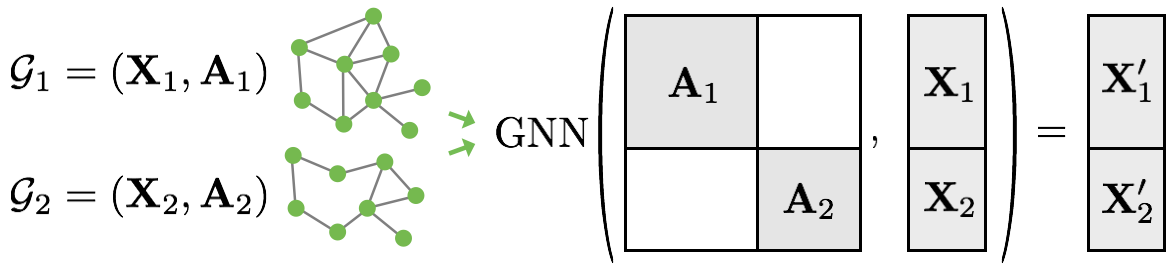

This procedure has some crucial advantages over other batching procedures:

1. GNN operators that rely on a message passing scheme do not need to be modified since messages are not exchanged between two nodes that belong to different graphs.

2. There is no computational or memory overhead since adjacency matrices are saved in a sparse fashion holding only non-zero entries, *i.e.*, the edges.

PyTorch Geometric automatically takes care of **batching multiple graphs into a single giant graph** with the help of the [`torch_geometric.data.DataLoader`](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.DataLoader) class:


In [29]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2636], x=[1188, 7], edge_attr=[2636, 4], y=[64], batch=[1188], ptr=[65])

Step 2:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2506], x=[1139, 7], edge_attr=[2506, 4], y=[64], batch=[1139], ptr=[65])

Step 3:
Number of graphs in the current batch: 22
DataBatch(edge_index=[2, 852], x=[387, 7], edge_attr=[852, 4], y=[22], batch=[387], ptr=[23])



Here, we opt for a `batch_size` of 64, leading to 3 (randomly shuffled) mini-batches, containing all $2 \cdot 64+22 = 150$ training graphs.

Furthermore, each `Batch` object is equipped with a **`batch` vector**, which maps each node to its respective graph in the batch:

$$
\textrm{batch} = [ 0, \ldots, 0, 1, \ldots, 1, 2, \ldots ]
$$

### Training the GNN
We'll follow the standard graph classification recipe:

1. Embed each node by performing multiple rounds of message passing
2. Aggregate node embeddings into a unified graph embedding (**readout layer**)
3. Train a final classifier on the graph embedding

There exists multiple **readout layers** in literature, but the most common one is to simply take the average of node embeddings:

$$
\mathbf{x}_{\mathcal{G}} = \frac{1}{|\mathcal{V}|} \sum_{v \in \mathcal{V}} \mathcal{x}^{(L)}_v
$$

PyTorch Geometric provides this functionality via [`torch_geometric.nn.global_mean_pool`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.glob.global_mean_pool), which takes in the node embeddings of all nodes in the mini-batch and the assignment vector `batch` to compute a graph embedding of size `[batch_size, hidden_channels]` for each graph in the batch.

The final architecture for applying GNNs to the task of graph classification then looks as follows and allows for complete end-to-end training:

In [30]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x

model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GCNConv(7, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


Here, we again make use of the [`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv) with $\mathrm{ReLU}(x) = \max(x, 0)$ activation for obtaining localized node embeddings, before we apply our final classifier on top of a graph readout layer.

Let's train our network for a few epochs to see how well it performs on the training as well as test set:

In [31]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(1, 171):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 002, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 003, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 004, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 005, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 006, Train Acc: 0.6533, Test Acc: 0.7368
Epoch: 007, Train Acc: 0.7467, Test Acc: 0.7632
Epoch: 008, Train Acc: 0.7267, Test Acc: 0.7632
Epoch: 009, Train Acc: 0.7200, Test Acc: 0.7632
Epoch: 010, Train Acc: 0.7133, Test Acc: 0.7895
Epoch: 011, Train Acc: 0.7200, Test Acc: 0.7632
Epoch: 012, Train Acc: 0.7200, Test Acc: 0.7895
Epoch: 013, Train Acc: 0.7200, Test Acc: 0.7895
Epoch: 014, Train Acc: 0.7133, Test Acc: 0.8421
Epoch: 015, Train Acc: 0.7133, Test Acc: 0.8421
Epoch: 016, Train Acc: 0.7533, Test Acc: 0.7368
Epoch: 017, Train Acc: 0.7400, Test Acc: 0.7632
Epoch: 018, Train Acc: 0.7133, Test Acc: 0.8421
Epoch: 019, Train Acc: 0.7400, Test Acc: 0.7895
Epoch: 020, Train Acc: 0.7533, Test Acc: 0.7368
Epoch: 021, Train Acc: 0.7467, Test Acc:

### Wrap Up
Our model reaches around **76% test accuracy**.
Reasons for the fluctations in accuracy can be explained by the rather small dataset (only 38 test graphs), and usually disappear once one applies GNNs to larger datasets.

## Bonus: GNNs as Simulators
Let's walk through this paper: [Learning to Simulate Complex Physics with Graph Networks](https://arxiv.org/pdf/2002.09405) ([video site](https://sites.google.com/view/learning-to-simulate#h.p_hjnaJ6k8y0wo) and [code repo](https://github.com/google-deepmind/deepmind-research/tree/master/learning_to_simulate)).